# Orbit extraction from Galform output  

This Notebook calculates the orbits of all galaxies found within 300 kpc (distance can be changed) of the MW progenitor for the MAGPIE project. It follows the most massive progenitor of each $z=0$ galaxy. The code does the following steps (each one is implemented as one or more functions):  

- Reads the most massive progenitor history and saves the position and velocity of this galaxy with respect to the MW progenitor. That is, the position and velocity of the MW analogue is 0 at each snapshot. **These are saved as `pos` and `vel` in the output hdf5 file.**  

- For all the snapshots a galaxy is a satellite, either type 1 = with surviving subhalo or type 2 = with destroyed subhalo, it finds the position and velocity of the central galaxy according to Galform. **These are saved as `pos_central` and `vel_central` in the output file.** The dataset `is_MW_central` keeps track if the central galaxy is actually the MW progenitor.  

- Reads the Subfind files to find the latest snapshot at which a galaxy is the central subhalo of an FOF halo. For that snapshot, it reads $M_{200~\rm{crit}}$, $R_{200~\rm{crit}}$ and $M_{2500~\rm{crit}}$, $R_{2500~\rm{crit}}$ and calculates the NFW concentration from those 4 values. This is the slowest bit of the code, probably because the Subfind files are split in too many files. 

**Note:** that a Galform central is different from a Subfind central subhalo. I think, in Galform a subhalo is a central galaxy as long as it hasn't entered the half mass radius of a more massive object. In Subfind, only the most massive subhalo in a FOF group is the central.

In [79]:
from matplotlib.backends.backend_pdf import PdfPages
import h5py                                    # To open snapshots
import numpy as np                             # Numerical library
# For quickly finding all snapshot paths
from glob import glob
from pyread_eagle import EagleSnapshot         # Eagle read routine
# Useful to get age of the universe and thus integration times
from astropy.cosmology import FlatLambdaCDM
# from eagle_database.database import Database   # Eagle database code

# plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline


plt.style.use("./shao.mplstyle")
fontSize = 15
lineWidth = 1.5

colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f',
          u'#bcbd22', u'#17becf']


In [186]:
from colossus.cosmology import cosmology
from astropy.cosmology import z_at_value
from astropy import units as unit
from astropy.coordinates import SkyCoord
params = {'flat': True, 'H0': 67.77, 'Om0': 0.307, 'Ob0': 0.04825, 'sigma8': 0.8288, 'ns': 0.9611}
cosmology.addCosmology('planck14', params)
cosmo = cosmology.setCosmology('planck14')

## Parameters to select the satellites  

Selects as satellites all the $z=0$ galaxies within the given distance from the central galaxy.

In [80]:
R_max = 300.  # physical kpc
Mstar_min = 1.  # in solar masses


## Path to the files used to read in the data and where to save the output  

- The `systems` list can be used to select a subset of the haloes for which to run the calculations. If `systems = None` then it calculates the orbits for all the main haloes.  
- The `central_index` is used to specify the index of the main galaxy at $z=0$. If `central_index = None` it selects the main galaxy with the largest halo mass, if a value `>=0` then it uses that `i-th` galaxy from the Galform file.

In [81]:
# specify for which entries below to calculate the satellite positions at each redshift
#systems = [16, 17, 18, 19]
systems = [0]

# central galaxy index (i.e.) position in the Galform file (one entry per system)
# only needed for the systems where the central is not a type=0 galaxy with the largest halo mass
# index of the galaxy in the Galform file dataset 'Output001'
centralIndeces = [
    0,    # M1_zcut7
    0,    # M2_zcut7
    0,    # M3_zcut7
    518,  # M4_zcut7
    79,   # M5_zcut7
    0,    # M1_7DM_GAS
    387,  # M2_7DM_GAS
    0,    # M3_7DM_GAS
    581,  # M4_7DM_GAS
    0,    # M5_7DM_GAS
    0,    # M1_MR_DMO
    0,    # M2_MR_DMO
    0,    # M3_MR_DMO
    597,  # M4_MR_DMO
    109,  # M5_MR_DMO
    0,    # M1_HR_DMO
    0,    # M2_HR_DMO
    0,    # M3_HR_DMO
    596,  # M4_HR_DMO
    0     # M5_HR_DMO
]

# path to the input files
root_galaxyFiles = "/home/zhaox/Magpie/Galform/"
list_galaxyFiles = [
    "M1_zcut7/galaxies.hdf5",
    "M2_zcut7/galaxies.hdf5",
    "M3_zcut7/galaxies.hdf5",
    "M4_zcut7/galaxies.hdf5",
    "M5_zcut7/galaxies.hdf5",
    "M1_7DM_GAS/galaxies.hdf5",
    "M2_7DM_GAS/galaxies.hdf5",
    "M3_7DM_GAS/galaxies.hdf5",
    "M4_7DM_GAS/galaxies.hdf5",
    "M5_7DM_GAS/galaxies.hdf5",
    "M1_MR_DMO/galaxies.hdf5",
    "M2_MR_DMO/galaxies.hdf5",
    "M3_MR_DMO/galaxies.hdf5",
    "M4_MR_DMO/galaxies.hdf5",
    "M5_MR_DMO/galaxies.hdf5",
    "M1_HR_DMO/galaxies.hdf5",
    "M2_HR_DMO/galaxies.hdf5",
    "M3_HR_DMO/galaxies.hdf5",
    "M4_HR_DMO/galaxies.hdf5",
    "M5_HR_DMO/galaxies.hdf5"
]

# path to the input particle data files
root_subhaloFiles = "/home/zhaox/Magpie/"
list_subhaloFiles = [
    "M1_zcut7/groups_%03i_z???p???/",
    "M2_zcut7/groups_%03i_z???p???/",
    "M3_zcut7/groups_%03i_z???p???/",
    "M4_zcut7/groups_%03i_z???p???/",
    "M5_zcut7/groups_%03i_z???p???/",
    "M1_7DM_GAS/groups_%03i_z???p???/",
    "M2_7DM_GAS/groups_%03i_z???p???/",
    "M3_7DM_GAS/groups_%03i_z???p???/",
    "M4_7DM_GAS/groups_%03i_z???p???/",
    "M5_7DM_GAS/groups_%03i_z???p???/",
    "M1_MR_DMO/groups_%03i_z???p???/",
    "M2_MR_DMO/groups_%03i_z???p???/",
    "M3_MR_DMO/groups_%03i_z???p???/",
    "M4_MR_DMO/groups_%03i_z???p???/",
    "M5_MR_DMO/groups_%03i_z???p???/",
    "M1_HR_DMO/groups_%03i_z???p???/",
    "M2_HR_DMO/groups_%03i_z???p???/",
    "M3_HR_DMO/groups_%03i_z???p???/",
    "M4_HR_DMO/groups_%03i_z???p???/",
    "M5_HR_DMO/groups_%03i_z???p???/"
]

# path to the output files
root_outputFiles = "./satellite_orbits_Galform/"
list_outputFiles = [
    "M1_MR.hdf5",
    "M2_MR.hdf5",
    "M3_MR.hdf5",
    "M4_MR.hdf5",
    "M5_MR.hdf5",
    "M1_7DM_GAS.hdf5",
    "M2_7DM_GAS.hdf5",
    "M3_7DM_GAS.hdf5",
    "M4_7DM_GAS.hdf5",
    "M5_7DM_GAS.hdf5",
    "M1_MR_DMO.hdf5",
    "M2_MR_DMO.hdf5",
    "M3_MR_DMO.hdf5",
    "M4_MR_DMO.hdf5",
    "M5_MR_DMO.hdf5",
    "M1_HR_DMO.hdf5",
    "M2_HR_DMO.hdf5",
    "M3_HR_DMO.hdf5",
    "M4_HR_DMO.hdf5",
    "M5_HR_DMO.hdf5"
]

# path to the output files for figures
plotFigures = True
root_plotFiles = root_outputFiles
list_plotFiles = [
    "M1_MR_orbits.pdf",
    "M2_MR_orbits.pdf",
    "M3_MR_orbits.pdf",
    "M4_MR_orbits.pdf",
    "M5_MR_orbits.pdf",
    "M1_7DM_GAS_orbits.pdf",
    "M2_7DM_GAS_orbits.pdf",
    "M3_7DM_GAS_orbits.pdf",
    "M4_7DM_GAS_orbits.pdf",
    "M5_7DM_GAS_orbits.pdf",
    "M1_MR_DMO_orbits.pdf",
    "M2_MR_DMO_orbits.pdf",
    "M3_MR_DMO_orbits.pdf",
    "M4_MR_DMO_orbits.pdf",
    "M5_MR_DMO_orbits.pdf",
    "M1_HR_DMO_orbits.pdf",
    "M2_HR_DMO_orbits.pdf",
    "M3_HR_DMO_orbits.pdf",
    "M4_HR_DMO_orbits.pdf",
    "M5_HR_DMO_orbits.pdf"
]

if systems is None:
    systems = list(range(len(centralIndeces)))


## Various functions used when performing the calculation

In [82]:
def findCentralGalaxy(hf):
    """Finds the central galaxy as the type=0 galaxy with the largest halo mass."""
    galType = np.array(hf['Output001/type'])
    Mhalo = np.array(hf['Output001/mhhalo'])
    Mhalo_max = Mhalo[galType == 0].max()
    print(Mhalo[galType == 0][:20])
    index = np.where((Mhalo == Mhalo_max) * (galType == 0))[0][0]
    return index, Mhalo[index]


def findSatellites(hf, centralIndex, maxDistance, minMstar):
    """Finds the satellites as all the galaxies within a given distance from the central galaxy."""
    pos = np.column_stack((np.array(hf['Output001/xgal']), np.array(hf['Output001/ygal']),
                           np.array(hf['Output001/zgal'])))
    Mstar = np.array(hf['Output001/mstars_bulge']) + \
        np.array(hf['Output001/mstars_disk'])
    pos0 = pos[centralIndex]
    pos = pos - pos0  # position relative to the central
    dis = (pos**2).sum(axis=1)  # distance from the central
    satellites = dis <= maxDistance**2
    satellites[centralIndex] = False  # remove the central galaxy
    satellites *= Mstar >= minMstar   # stellar mass selection
    return np.where(satellites)[0]


In [83]:
# read all the positions at the selected output
# find the closest central when normalized by virial radius
# if central in current set, copy that info; if not read from the file
# find second central if current central fall inside another halo not the MW progenitor


def findHost(hf, sat_pos, out_index):
    """Finds the first central galaxy at the infall snapshot of a satellite."""
    dataset = 'Output%03i/' % (out_index+1)

    # select central galaxies
    temp_central = np.array(hf[dataset+'is_central'])
    sel = temp_central == 1

    # get the ids and positions of all centrals
    temp_IDs = np.array(hf[dataset+'GalaxyID'])[sel]
    temp_pos = np.column_stack((np.array(hf[dataset+'xgal']), np.array(hf[dataset+'ygal']),
                                np.array(hf[dataset+'zgal'])))[sel]
    temp_dis = ((temp_pos - sat_pos[None, :])**2).sum(axis=1)
    temp_Rhalo = np.array(hf[dataset+'halo_r_virial'])[sel]

    target = np.argmin(temp_dis / temp_Rhalo)
    return temp_IDs[target]


def findMergerTree_central(hf, sat_pos, out_index, MW_ID, MW_pos, MW_vel):
    "Finds the position and velocity of the central galaxy for satellites at each snapshot."
    target_ID = findHost(hf, sat_pos, out_index)  # find the central at infall
    matched = np.where(target_ID == MW_ID)[0]
    if len(matched) >= 1:  # the satellite fell into the MW analogue
        return MW_pos[:out_index+1], MW_vel[:out_index+1], True

    # find the position and velocities of the central galaxy
    pos = np.zeros((out_index+1, 3), np.float64)
    vel = np.zeros((out_index+1, 3), np.float64)
    MWa = np.zeros((out_index+1), bool)
    for i in range(out_index, 0, -1):
        dataset = 'Output%03i/' % (i+1)
        temp_IDs = np.array(hf[dataset+'GalaxyID'])
        sel = temp_IDs == target_ID  # select the target galaxy
#         print(i, target_ID, sel.sum())

        # check if it is central or not
        if np.array(hf[dataset+'is_central'])[sel][0]:  # target galaxy is a central
            target_ID = np.array(hf[dataset+'DescendantID'])[sel][0]
            pos[i, 0] = np.array(hf[dataset+'xgal'])[sel]
            pos[i, 1] = np.array(hf[dataset+'ygal'])[sel]
            pos[i, 2] = np.array(hf[dataset+'zgal'])[sel]
            vel[i, 0] = np.array(hf[dataset+'vxgal'])[sel]
            vel[i, 1] = np.array(hf[dataset+'vygal'])[sel]
            vel[i, 2] = np.array(hf[dataset+'vzgal'])[sel]
        else:  # target galaxy is a satellite, so return position of its own central
            sat_pos = np.column_stack((np.array(hf[dataset+'xgal']), np.array(hf[dataset+'ygal']),
                                       np.array(hf[dataset+'zgal'])))[sel][0]
            pos[:i+1], vel[:i+1], MWa[:i +
                                      1] = findMergerTree_central(hf, sat_pos, i, MW_ID, MW_pos, MW_vel)
            break
    return pos, vel, MWa


# with h5py.File( galaxyFile, 'r' ) as hf:
#     gal_central_pos = np.zeros( (numObjs,numSnaps,3), np.float64 )
#     gal_central_vel = np.zeros( (numObjs,numSnaps,3), np.float64 )
#     gal_central_MW = np.zeros( (numObjs,numSnaps), bool )
#     for j in range(1,numObjs):
#         k = gal_indexCen[j] - 1
#         if k < 0: # this is a central at z=0
#             continue
#         gal_central_pos[j,:k+1], gal_central_vel[j,:k+1], gal_central_MW[j,:k+1] = \
#                 findMergerTree_central(hf, gal_pos[j,k], k, gal_ID[0], gal_pos[0], gal_vel[0] )


In [84]:
def readActualData(hf, numObjs, numSnaps, gal_ID_start, gal_ID_end):
    """Reads the data for the most massive progenitor of z=0 galaxies at each redshift they exist."""
    # quantities that store redshift info
    # reserve memory for the main progenitor of each z=0 galaxy
    gal_ID = -np.ones((numObjs, numSnaps), np.int64)
    gal_type = -np.ones((numObjs, numSnaps), np.int32)
    gal_pos = np.zeros((numObjs, numSnaps, 3), np.float64)
    gal_vel = np.zeros((numObjs, numSnaps, 3), np.float64)
    gal_Mstar = np.zeros((numObjs, numSnaps), np.float64)  # stellar mass
    # half stellar mass radius
    gal_RHalf = np.zeros((numObjs, numSnaps), np.float64)
    gal_Mhalo = np.zeros((numObjs, numSnaps), np.float64)  # host halo mass
    # subhalo index in Subfind catalogue
    gal_subIndex = -np.ones((numObjs, numSnaps), np.int32)
    # snapnum*10^12+filenum*10^8+gal_subIndex
    gal_subID = -np.ones((numObjs, numSnaps), np.int64)

    # loop over each snapshot and read the position and other properties of the main galaxy progenitor
    print("\tReading the info at each Galform output ...")
    for i in range(1, numSnaps+1):
        dataset = 'Output%03i/' % i
        if dataset[:-1] in hf.keys() and 'GalaxyID' in hf[dataset].keys():
            temp_index = np.empty(numObjs, np.int32)
            temp_ID = np.array(hf[dataset + 'GalaxyID'])
            for j in range(numObjs):
                current_index = np.where(
                    (temp_ID >= gal_ID_start[j]) * (temp_ID <= gal_ID_end[j]))[0]
                temp_index[j] = current_index[0] if len(
                    current_index) > 0 else -1

            # get the number of objects with a progenitor at this redshift
            valid = temp_index >= 0
            if valid.sum() == 0:  # no progenitor present
                continue
            if i % 10 == 0:
                print("\t\toutput %i has %i progenitors" % (i, valid.sum()))
            temp_index = temp_index[valid]
            gal_ID[:, i-1][valid] = temp_ID[temp_index]
            gal_type[:, i -
                     1][valid] = np.array(hf[dataset + 'type'])[temp_index]
            gal_pos[:, i-1][valid] = np.column_stack((np.array(hf[dataset+'xgal']),
                                                      np.array(
                                                          hf[dataset+'ygal']),
                                                      np.array(hf[dataset+'zgal'])))[temp_index]
            gal_vel[:, i-1][valid] = np.column_stack((np.array(hf[dataset+'vxgal']),
                                                      np.array(
                                                          hf[dataset+'vygal']),
                                                      np.array(hf[dataset+'vzgal'])))[temp_index]
            # sum the bulge and disk stellar masses
            gal_Mstar[:, i-1][valid] = np.array(hf[dataset + 'mstars_bulge'])[temp_index] + \
                np.array(hf[dataset + 'mstars_disk'])[temp_index]
            # calculate the half stellar mass radius as a weighted mean of the bulge and disk values
            gal_RHalf[:, i-1][valid] = (np.array(hf[dataset + 'mstars_bulge'])[temp_index] *
                                        np.array(hf[dataset + 'rbulge'])[temp_index] +
                                        np.array(hf[dataset + 'mstars_disk'])[temp_index] *
                                        np.array(hf[dataset + 'rdisk'])[temp_index]) / \
                gal_Mstar[:, i-1][valid]
            gal_Mhalo[:, i -
                      1][valid] = np.array(hf[dataset + 'mchalo'])[temp_index]
            gal_subIndex[:, i -
                         1][valid] = np.array(hf[dataset + 'SubhaloIndex'])[temp_index]
            gal_subID[:, i -
                      1][valid] = np.array(hf[dataset + 'SubhaloID'])[temp_index]

    return gal_ID, gal_type, gal_pos, gal_vel, gal_Mstar, gal_RHalf, gal_Mhalo, gal_subIndex, gal_subID


def readGalformGalaxyData(galaxyFile, centralIndex, R_max, Mstar_min):
    """Reads the galaxy data within a Galform file. 

    Finds the most massive galaxy defined as the one with position 'centralIndex' 
    in the file and finds all its satellites, i.e. all galaxies within `R_max`
    with stellar mass larger than `Mstar_min`. 

    Returns multiple properties of the satellites and of their most massive progenitor.

    Also calculates the position and velocities of the central galaxy at each snapshot
    for all satellite progenitors.
    """
    with h5py.File(galaxyFile, 'r') as hf:
        # read the cosmology and snapshot info
        h = np.array(hf['Parameters/h0'])
        Omega0 = np.array(hf['Parameters/omega0'])
        OmegaB = np.array(hf['Parameters/omegab'])
        print("\tcosmological parameters (h, Omega_M, Omega_B): ", h, Omega0, OmegaB)

        redshift = np.array(hf['Output_Times/zout'])
        time = np.array(hf['Output_Times/tout'])
        scale_factor = np.array(hf['Output_Times/aout'])
        snap_number = np.array(hf['Output_Times/snapnum_out'])

        # find the central galaxy
        if centralIndex is None:
            centralIndex, Mhalo_max = findCentralGalaxy(hf)
            print("\tcentral galaxy index and Mhalo/1.e12: ",
                  centralIndex, Mhalo_max/1.e12/h)

        # find the satellites
        satelliteIndex = findSatellites(
            hf, centralIndex, R_max/1.e3*h, Mstar_min*h)
        print("\tthere are %i satellites within %.0f kpc from the central and with Mstar above %.2e Msolar"
              % (satelliteIndex.shape[0], R_max, Mstar_min))

        # Arrays for keeping track of info needed for identifying the most massive progenitor
        numObjs = 1 + satelliteIndex.shape[0]
        indices = np.hstack((centralIndex, satelliteIndex))
        # first ID of each galaxy
        gal_ID_start = np.array(hf['Output001/GalaxyID'])[indices]
        # last main progenitor
        gal_ID_end = np.array(hf['Output001/EndMainBranchID'])[indices]

        # read the snapshot info
        numSnaps = snap_number.shape[0]
        print("\tnumber of snapshots in the file: ", numSnaps)
        gal_ID, gal_type, gal_pos, gal_vel, gal_Mstar, gal_RHalf, gal_Mhalo, gal_subIndex, gal_subID = \
            readActualData(hf, numObjs, numSnaps, gal_ID_start, gal_ID_end)

        # find the pos and velocity of the central galaxy for satellites
        # index at which the galaxy was last a central
        # last a value when galaxy was central
        gal_acHalo = np.array(hf['Output001/achalo'])[indices]
        gal_indexCen = np.interp(
            gal_acHalo, scale_factor[::-1], range(numSnaps)[::-1]).astype(np.int32)
        # alternatively can do this
        # gal_indexCen = np.argmin( np.abs(gal_acHalo[:, None] - scale_factor[None, :]), axis = 1)

        gal_central_pos = np.zeros((numObjs, numSnaps, 3), np.float64)
        gal_central_vel = np.zeros((numObjs, numSnaps, 3), np.float64)
        gal_central_MW = np.zeros((numObjs, numSnaps), bool)
        for j in range(1, numObjs):
            k = gal_indexCen[j] - 1
            if k < 0:  # this is a central at z=0
                continue
            gal_central_pos[j, :k+1], gal_central_vel[j, :k+1], gal_central_MW[j, :k+1] = \
                findMergerTree_central(
                    hf, gal_pos[j, k], k, gal_ID[0], gal_pos[0], gal_vel[0])

    return h, Omega0, OmegaB, redshift, time, scale_factor, snap_number, \
        gal_ID, gal_type, gal_pos, gal_vel, gal_Mstar, gal_RHalf, gal_Mhalo, gal_subIndex, gal_subID, \
        gal_indexCen, gal_central_pos, gal_central_vel, gal_central_MW


In [123]:
# function for reading in the Subfind data
def readSubhalomass(subhaloFile, gal_subID):
    """Reads the group data from a Subfind file."""
    subfile_basename = 'eagle_subfind_tab_???_z???p???.%i.hdf5'
    # create array for subhalo mass
    numObjs = gal_subID.shape[0]
    numSnaps = gal_subID.shape[1]
    gal_Msub = np.zeros((numObjs, numSnaps), np.float64)
    gal_GroupNumber = np.zeros((numObjs, numSnaps), int)
    gal_SubGroupNumber = np.zeros((numObjs, numSnaps), int)
    for i in range(0, numObjs):
        for j in range(0, numSnaps):
            if j == 0 and i % 10 == 0:
                print("\t\t %ith galaxy finished" % (i))
            if gal_subID[i, j] < 0:
                continue
            ID_temp = gal_subID[i, j]
            a = divmod(ID_temp, 10**15)  # a[0] > 0 if no subhalo exists
            b = divmod(a[1], 10**12)    # b[0] is snapnum
            # c[0] is the file number and c[1] is the index of the subhalo
            c = divmod(b[1], 10**8)
            snapname = subhaloFile % b[0]
            subfilename = snapname + subfile_basename
            inputFiles = glob(subfilename % c[0])
            # find and read the file
            with h5py.File(inputFiles[0], 'r') as hf:
                #           print( hf['Header'].attrs.keys() )    # returns the names of all the attributes in the header
                HubbleParam = hf['Header'].attrs['HubbleParam']
                numGroups = hf['Header'].attrs['TotNgroups']
                numSubgroups = hf['Header'].attrs['TotNsubgroups']
                gal_Msub[i, j] = np.array(
                    hf['Subhalo/Mass'])[c[1]] * 1.e10 / HubbleParam
                gal_GroupNumber[i, j] = np.array(hf['Subhalo/GroupNumber'])[c[1]]
                gal_SubGroupNumber[i, j] = np.array(hf['Subhalo/SubGroupNumber'])[c[1]]
    return gal_Msub, gal_GroupNumber, gal_SubGroupNumber

# function for reading in the FoF data


def readFOFHaloData(inputFile):
    """Reads the group data from a Subfind file."""
    inputFile = inputFile + 'eagle_subfind_tab_???_z???p???.*.hdf5'
    inputFiles = glob(inputFile)
    inputFiles.sort()

    # read the total number of groups and subgroups in the file
    with h5py.File(inputFiles[0], 'r') as hf:
        #         print( hf['Header'].attrs.keys() )    # returns the names of all the attributes in the header
        HubbleParam = hf['Header'].attrs['HubbleParam']
        numGroups = hf['Header'].attrs['TotNgroups']
        numSubgroups = hf['Header'].attrs['TotNsubgroups']
        numFiles = len(inputFiles)
#     print( "The '%s' catalogue contains %i groups and %i subgroups that are saved in %i files." \
#           % (inputFiles[0], numGroups, numSubgroups, numFiles) )
#     print( "\t", inputFiles[0] )

    # reserve numpy arrays to quickly read the data
    M200 = np.empty(numGroups, np.float32)
    R200 = np.empty(numGroups, np.float32)
    M2500 = np.empty(numGroups, np.float32)
    R2500 = np.empty(numGroups, np.float32)
    pos = np.empty((numGroups, 3), np.float64)
    numSubs = np.empty(numGroups, np.int32)

    start, end = 0, 0
    for i in range(numFiles):
        with h5py.File(inputFiles[i], 'r') as hf:
            end = start + hf['Header'].attrs['Ngroups']
            if end > start:  # the file contains group data
                M200[start:end] = np.array(
                    hf['FOF/Group_M_Crit200']) * 1.e10 / HubbleParam
                R200[start:end] = np.array(
                    hf['FOF/Group_R_Crit200']) * 1.e3 / HubbleParam
                M2500[start:end] = np.array(
                    hf['FOF/Group_M_Crit2500']) * 1.e10 / HubbleParam
                R2500[start:end] = np.array(
                    hf['FOF/Group_R_Crit2500']) * 1.e3 / HubbleParam
                pos[start:end] = np.array(hf['FOF/GroupCentreOfPotential'])
                numSubs[start:end] = np.array(hf['FOF/NumOfSubhalos'])
                start = end
    sel = numSubs > 0
    return M200[sel], R200[sel], M2500[sel], R2500[sel], pos[sel]


def findNFWConcentration(M200, R200, M1, R1, cmin=1, cmax=50):
    """Calculate the NFW concentration given two enclosed mass measurements at two different radii."""
    def func(c): return M200 * (np.log(1.+c*R1/R200) - c *
                                R1/(R200+c*R1)) / (np.log(1.+c) - c/(1.+c)) - M1
    conc = np.logspace(np.log10(cmin), np.log10(cmax), 1000)
    index = np.argmin(np.abs(func(conc)))
    return conc[index]


def readHaloProfile(inputFile, snap_number, gal_indexCen, gal_pos):
    """Finds for each satellite the snapshot at which it was a Subfind central.
    At that time, reads in the M200, R200 as well as the 2500 values and calculates the NFW concentration."""
    # find all the satellites that were last centrals at each snapshot
    # if any such objects, read in the SubFind files and get the M200, R200, Vmax and Rmax values
    numObjs = gal_pos.shape[0]
    numSnaps = gal_pos.shape[1]
    gal_M200 = np.zeros(numObjs, np.float64)
    gal_R200 = np.zeros(numObjs, np.float64)
    gal_conc = np.zeros(numObjs, np.float64)

    # there could be differences between the definition of a Galform central and Subfind central
    # the code checks if a galaxy is a subfind central, and, if not,
    # keeps track to check the subfind catalogue at the previous snapshot
    gal_indexCen_sub = gal_indexCen.copy()

    for i in range(0, numSnaps):
        indices = np.where(gal_indexCen_sub == i)[0]
        if len(indices) == 0:  # no centrals in this snapshot, so skip
            continue
        print("\t\tsnapshot",
              snap_number[i], "searching host halo for:", indices, end="\n")

        # read the Subfind files -- read only M200, R200, Vmax and Rmax
        subhaloFile = inputFile % snap_number[i]
        M200, R200, M2500, R2500, pos = readFOFHaloData(subhaloFile)

        # for each satellite that is a central for the last time at this snapshot, find its halo properties
        for j in indices:
            temp_dis = ((pos-gal_pos[j, i])**2).sum(axis=1)
            temp_index = np.argmin(temp_dis)
            if temp_dis[temp_index] < 1.e-6:  # subhalo coincides with group centre
                gal_M200[j] = M200[temp_index]
                gal_R200[j] = R200[temp_index]
                gal_conc[j] = findNFWConcentration(M200[temp_index], R200[temp_index],
                                                   M2500[temp_index], R2500[temp_index])
            else:  # subhalo is not a subfind central, so check again at the previous snapshot
                gal_indexCen_sub[j] += 1

    return gal_M200, gal_R200, gal_conc, gal_indexCen_sub


In [86]:


def writeSatelliteData(outputFile, gal_ID, gal_type, gal_pos, gal_vel, gal_Mstar, gal_Mhalo, gal_RHalf, gal_Msub,
                       gal_M200, gal_R200, gal_conc, gal_snap_FOF_lastCentral,
                       gal_snap_lastCentral, gal_central_pos, gal_central_vel, gal_central_MW,
                       redshift, time, scale_factor, snap_number, h, Omega0, OmegaB):
    """Writes the central galaxy and satellite data in a hdf5 file."""
    with h5py.File(outputFile, 'w') as hf:
        g1 = hf.create_group("header_info")
        d1 = g1.create_dataset('redshift', data=redshift, dtype='f4')
        d1.attrs["description"] = "The redshift of each snapshot."
        d1 = g1.create_dataset('time', data=time, dtype='f4')
        d1.attrs["description"] = "The age of the universe in Gyrs at the time of the snapshot."
        d1 = g1.create_dataset('scale_factor', data=scale_factor, dtype='f4')
        d1.attrs["description"] = "The expansion factor at the given snapshot."
        d1 = g1.create_dataset('snap_number', data=snap_number, dtype='i')
        d1.attrs["description"] = "The snapshot number."
        d1 = g1.create_dataset('h', data=h, dtype='f4')
        d1.attrs["description"] = "The Hubble h0 value."
        d1 = g1.create_dataset('Omega0', data=Omega0, dtype='f4')
        d1.attrs["description"] = "The fractional amount of matter at z=0."
        d1 = g1.create_dataset('OmegaB', data=OmegaB, dtype='f4')
        d1.attrs["description"] = "The fractional amount of baryons at z=0."

        # write the central galaxy data
        g1 = hf.create_group("central_galaxy")
        d1 = g1.create_dataset('ID', data=gal_ID[0], dtype='i')
        d1.attrs["description"] = "The Galform galaxy ID at each snapshot."
        d1 = g1.create_dataset('pos', data=gal_pos[0], dtype='f8')
        d1.attrs["description"] = "The galaxy pos (x,y,z) in physical kpc at each snapshot."
        d1 = g1.create_dataset('vel', data=gal_vel[0], dtype='f8')
        d1.attrs["description"] = "The galaxy velocity (Vx,Vy,Vz) in km/s at each snapshot."
        d1 = g1.create_dataset('type', data=gal_type[0], dtype='i')
        d1.attrs["description"] = "The galaxy type at each snapshot."
        d1 = g1.create_dataset('Mstar', data=gal_Mstar[0], dtype='f8')
        d1.attrs["description"] = "The galaxy stellar mass in Msolar at each snapshot."
        d1 = g1.create_dataset('Mhalo', data=gal_Mhalo[0], dtype='f8')
        d1.attrs["description"] = "The mass in Msolar of the host halo in last snapshot galaxy was a central."

        # write the satellite galaxy data
        g1 = hf.create_group("satellite_galaxies")
        d1 = g1.create_dataset('ID', data=gal_ID[1:], dtype='i')
        d1.attrs["description"] = "The Galform galaxy ID at each snapshot."
        d1 = g1.create_dataset('pos', data=gal_pos[1:], dtype='f8')
        d1.attrs["description"] = "The galaxy pos (x,y,z) in physical kpc at each snapshot. Pos w.r.t. MW progenitor."
        d1 = g1.create_dataset('vel', data=gal_vel[1:], dtype='f8')
        d1.attrs["description"] = "The galaxy velocity (Vx,Vy,Vz) in km/s at each snapshot. Vel w.r.t. MW progenitor."
        d1 = g1.create_dataset('snap_last_central',
                               data=gal_snap_lastCentral[1:], dtype='i')
        d1.attrs["description"] = "Last snapshot at which the galaxy was a central."
        d1 = g1.create_dataset(
            'pos_central', data=gal_central_pos[1:], dtype='f8')
        d1.attrs["description"] = "The pos (x,y,z) of the central of this galaxy in physical kpc at each snapshot. Pos w.r.t. MW progenitor."
        d1 = g1.create_dataset(
            'vel_central', data=gal_central_vel[1:], dtype='f8')
        d1.attrs["description"] = "The velocity (Vx,Vy,Vz) of the central of this galaxy in km/s at each snapshot. Vel w.r.t. MW progenitor."
        d1 = g1.create_dataset(
            'is_MW_central', data=gal_central_MW[1:], dtype=bool)
        d1.attrs["description"] = "True if the central of this galaxy is the MW progenitor."
        d1 = g1.create_dataset('type', data=gal_type[1:], dtype='i')
        d1.attrs["description"] = "True if the central of this galaxy is the MW progenitor."
        d1 = g1.create_dataset('RstarHalf', data=gal_RHalf[1:], dtype='f8')
        d1.attrs[
            "description"] = "The half stellar mass radius of the galaxy at each snapshot (weighted mean of the disk and bulge values)."
        d1 = g1.create_dataset('Mstar', data=gal_Mstar[1:], dtype='f8')
        d1.attrs["description"] = "The galaxy stellar mass in Msolar at each snapshot."
        d1 = g1.create_dataset('Mhalo', data=gal_Mhalo[1:], dtype='f8')
        d1.attrs["description"] = "The mass in Msolar of the host halo in last snapshot galaxy was a central."
        d1 = g1.create_dataset('Msub', data=gal_Msub[1:], dtype='f8')
        d1.attrs["description"] = "The mass of subhalo."

        d1 = g1.create_dataset('M200', data=gal_M200[1:], dtype='f8')
        d1.attrs["description"] = "The 200 rho_crit mass at last snapshot the galaxy is a central inside an FOF group."
        d1 = g1.create_dataset('R200', data=gal_R200[1:], dtype='f8')
        d1.attrs["description"] = "The 200 rho_crit radius at last snapshot the galaxy is a central inside an FOF group."
        d1 = g1.create_dataset('conc', data=gal_conc[1:], dtype='f8')
        d1.attrs["description"] = "The concentration at the last snapshot the galaxy is a central inside an FOF group."
        d1 = g1.create_dataset('snap_last_FOF_central',
                               data=gal_snap_FOF_lastCentral[1:], dtype='i')
        d1.attrs["description"] = "Last snapshot at which the galaxy is a FOF central subhalo. Different from Galform definition of central galaxy."

        grp = hf.create_group("metadata")
        grp.attrs["units"] = np.string_(
            "Positions: kpc;  Velocities: km/s;  Masses: Msolar")
        grp.attrs["num_centrals"] = 1
        grp.attrs["num_satellites"] = gal_ID.shape[0] - 1
        grp.attrs["program_options"] = "Obtained using the 'Extract_orbit_history_from_Galfrom.ipynb' jupyter notebook"


In [87]:
def plotCentralGalaxy(time, gal_ID, gal_Mstar, gal_Mhalo, gal_pos, gal_vel):
    s = gal_ID[0] >= 0  # select only valid entries

    fig1 = plt.figure(figsize=(2*7.5, 3*5))
    gs = gridspec.GridSpec(3, 2)
    # fig1.suptitle( "Position and velocity of the main galaxy" )

    ax1 = plt.subplot(gs[0])
    plt.xlabel(r'time [Gyrs]')
    plt.ylabel(r'M$_{\star}$ [M$_{\odot}$]')
    plt.semilogy(time[s], gal_Mstar[0][s], '-', c=colors[0])
    plt.scatter(time[s], gal_Mstar[0][s], c=time[s], s=20)

    ax1 = plt.subplot(gs[1])
    plt.xlabel(r'time [Gyrs]')
    plt.ylabel(r'M$_{\rm halo}$ [M$_{\odot}$]')
    plt.semilogy(time[s], gal_Mhalo[0][s], '-', c=colors[0])
    plt.scatter(time[s], gal_Mhalo[0][s], c=time[s], s=20)

    ax1 = plt.subplot(gs[2])
    plt.xlabel('X [kpc]')
    plt.ylabel('Y [kpc]')
    pos_x = gal_pos[0, :, 0][s] - gal_pos[0, 0, 0]
    pos_y = gal_pos[0, :, 1][s] - gal_pos[0, 0, 1]
    pos_z = gal_pos[0, :, 2][s] - gal_pos[0, 0, 2]
    plt.plot(pos_x, pos_y, '-', c=colors[0])
    plt.scatter(pos_x, pos_y, c=time[s])

    ax1 = plt.subplot(gs[3])
    plt.xlabel('X [kpc]')
    plt.ylabel('Z [kpc]')
    plt.plot(pos_x, pos_z, '-', c=colors[0])
    plt.scatter(pos_x, pos_z, c=time[s])

    ax1 = plt.subplot(gs[4])
    plt.xlabel(r'V$_{X}$ [km/s]')
    plt.ylabel(r'V$_{Y}$ [km/s]')
    plt.plot(gal_vel[0, :, 0][s], gal_vel[0, :, 1][s], '-', c=colors[0])
    plt.scatter(gal_vel[0, :, 0][s], gal_vel[0, :, 1][s], c=time[s])

    ax1 = plt.subplot(gs[5])
    plt.xlabel(r'V$_{X}$ [km/s]')
    plt.ylabel(r'V$_{Z}$ [km/s]')
    plt.plot(gal_vel[0, :, 0][s], gal_vel[0, :, 2][s], '-', c=colors[0])
    plt.scatter(gal_vel[0, :, 0][s], gal_vel[0, :, 2][s], c=time[s], s=20)

    return fig1

# x = plotCentralGalaxy(time, gal_ID, gal_Mstar, gal_Mhalo, gal_pos, gal_vel)


def plotSatellites(time, gal_ID, gal_Mstar, gal_Mhalo, gal_Msub, gal_pos, gal_central_pos, range1, range2):
    fig1 = plt.figure(figsize=(2*7.5, 4*5))
    gs = gridspec.GridSpec(4, 2)

    s = gal_ID[0] >= 0
    R200 = 227.2 * (gal_Mhalo[0][s]/1.252e12)**0.3333

    ax1 = plt.subplot(gs[0])
    plt.ylim([1.e1, 1.e10])
    ax1 = plt.subplot(gs[1])
    plt.ylim([1.e1, 1.e10])

    ax1 = plt.subplot(gs[2])
    plt.ylim([1.e6, 1.e12])
    ax1 = plt.subplot(gs[3])
    plt.ylim([1.e6, 1.e12])

    ax1 = plt.subplot(gs[4])
    plt.ylim([1.e1, 1.e3])
    plt.semilogy(time[s], R200, '-', lw=2, c="0.5", alpha=0.5)

    ax1 = plt.subplot(gs[5])
    plt.ylim([1.e1, 1.e3])
    plt.semilogy(time[s], R200, '-', lw=2, c="0.5", alpha=0.5)

    ax1 = plt.subplot(gs[6])
    plt.ylim([1.e1, 1.e3])
    plt.semilogy(time[s], R200, '-', lw=2, c="0.5", alpha=0.5)

    ax1 = plt.subplot(gs[7])
    plt.ylim([1.e1, 1.e3])
    plt.semilogy(time[s], R200, '-', lw=2, c="0.5", alpha=0.5)

    for i in range1:
        s = gal_ID[i] >= 0
        s0 = s * gal_type[i] == 0
        s1 = s * gal_type[i] == 1
        s2 = s * gal_type[i] == 2

        ax1 = plt.subplot(gs[0])
        plt.xlabel(r'time [Gyrs]')
        plt.ylabel(r'M$_{\star}$ [M$_{\odot}$]')
        plt.semilogy(time[s0], gal_Mstar[i][s0],
                     '-', lw=2, c=colors[(i-1) % 5])
        plt.semilogy(time[s1], gal_Mstar[i][s1],
                     '--', lw=2, c=colors[(i-1) % 5])
        plt.semilogy(time[s2], gal_Mstar[i][s2],
                     ':', lw=2, c=colors[(i-1) % 5])

        ax1 = plt.subplot(gs[2])
        plt.xlabel(r'time [Gyrs]')
        plt.ylabel(r'M$_{\rm halo}$ [M$_{\odot}$]')
        plt.semilogy(time[s0], gal_Mhalo[i][s0], '-', lw=2,
                     c=colors[(i-1) % 5], label="%i" % i)
        plt.semilogy(time[s1], gal_Mhalo[i][s1],
                     '--', lw=2, c=colors[(i-1) % 5])
        plt.semilogy(time[s2], gal_Mhalo[i][s2],
                     ':', lw=2, c=colors[(i-1) % 5])
        plt.semilogy(time, gal_Msub[i], ls='dashdot',
                     lw=2, c=colors[(i-1) % 5])

        ax1 = plt.subplot(gs[4])
        dis = np.sqrt((gal_pos[i]**2).sum(axis=1))
        plt.xlabel(r'time [Gyrs]')
        plt.ylabel(r'r [kpc]')
        plt.semilogy(time[s0], dis[s0], '-', lw=2, c=colors[(i-1) % 5])
        plt.semilogy(time[s1], dis[s1], '--', lw=2, c=colors[(i-1) % 5])
        plt.semilogy(time[s2], dis[s2], ':', lw=2, c=colors[(i-1) % 5])

        ax1 = plt.subplot(gs[6])
        dis = np.sqrt(((gal_central_pos[i]-gal_pos[i])**2).sum(axis=1))
        plt.xlabel(r'time [Gyrs]')
        plt.ylabel(r'r [kpc]')
        plt.semilogy(time[s0], dis[s0], '-', lw=2, c=colors[(i-1) % 5])
        plt.semilogy(time[s1], dis[s1], '--', lw=2, c=colors[(i-1) % 5])
        plt.semilogy(time[s2], dis[s2], ':', lw=2, c=colors[(i-1) % 5])

    for i in range2:
        s = gal_ID[i] >= 0
        s0 = s * gal_type[i] == 0
        s1 = s * gal_type[i] == 1
        s2 = s * gal_type[i] == 2

        ax1 = plt.subplot(gs[1])
        plt.xlabel(r'time [Gyrs]')
        plt.ylabel(r'M$_{\star}$ [M$_{\odot}$]')
        plt.semilogy(time[s0], gal_Mstar[i][s0],
                     '-', lw=2, c=colors[(i-1) % 5])
        plt.semilogy(time[s1], gal_Mstar[i][s1],
                     '--', lw=2, c=colors[(i-1) % 5])
        plt.semilogy(time[s2], gal_Mstar[i][s2],
                     ':', lw=2, c=colors[(i-1) % 5])

        ax1 = plt.subplot(gs[3])
        plt.xlabel(r'time [Gyrs]')
        plt.ylabel(r'M$_{\rm halo}$ [M$_{\odot}$]')
        plt.semilogy(time[s0], gal_Mhalo[i][s0], '-', lw=2,
                     c=colors[(i-1) % 5], label="%i" % i)
        plt.semilogy(time[s1], gal_Mhalo[i][s1],
                     '--', lw=2, c=colors[(i-1) % 5])
        plt.semilogy(time[s2], gal_Mhalo[i][s2],
                     ':', lw=2, c=colors[(i-1) % 5])
        plt.semilogy(time, gal_Msub[i], ls='dashdot',
                     lw=2, c=colors[(i-1) % 5])

        ax1 = plt.subplot(gs[5])
        dis = np.sqrt((gal_pos[i]**2).sum(axis=1))
        plt.xlabel(r'time [Gyrs]')
        plt.ylabel(r'r [kpc]')
        plt.semilogy(time[s0], dis[s0], '-', lw=2, c=colors[(i-1) % 5])
        plt.semilogy(time[s1], dis[s1], '--', lw=2, c=colors[(i-1) % 5])
        plt.semilogy(time[s2], dis[s2], ':', lw=2, c=colors[(i-1) % 5])

        ax1 = plt.subplot(gs[7])
        dis = np.sqrt(((gal_central_pos[i]-gal_pos[i])**2).sum(axis=1))
        plt.xlabel(r'time [Gyrs]')
        plt.ylabel(r'r [kpc]')
        plt.semilogy(time[s0], dis[s0], '-', lw=2, c=colors[(i-1) % 5])
        plt.semilogy(time[s1], dis[s1], '--', lw=2, c=colors[(i-1) % 5])
        plt.semilogy(time[s2], dis[s2], ':', lw=2, c=colors[(i-1) % 5])

    if len(range1) > 0:
        ax1 = plt.subplot(gs[2])
        plt.legend()  # ncol=len(range1) )

    if len(range2) > 0:
        ax1 = plt.subplot(gs[3])
        plt.legend()  # ncol=len(range2) )

    return fig1

# x = plotSatellites(time, gal_ID, gal_Mstar, gal_Mhalo, gal_pos, list(range(1,6)), list(range(6,11)) )


def plotEntries(fileName, time, gal_ID, gal_Mstar, gal_Mhalo, gal_Msub, gal_pos, gal_vel, gal_central_pos):
    numSats = gal_ID.shape[0]
    figs = []

    # plot the central galaxy
    figs.append(plotCentralGalaxy(
        time, gal_ID, gal_Mstar, gal_Mhalo, gal_pos, gal_vel))

    # plot the satellites, 10 on a page
    count = 1
    while numSats - count > 0:
        range1 = [i for i in range(count+0, count + 5) if i < numSats]
        range2 = [i for i in range(count+5, count+10) if i < numSats]
        figs.append(plotSatellites(time, gal_ID, gal_Mstar, gal_Mhalo,
                                   gal_Msub, gal_pos, gal_central_pos, range1, range2))
        count += 10

    # save the figures to a file
    pp = PdfPages(fileName)
    for fig in figs:
        pp.savefig(fig, bbox_inches='tight')
    pp.close()

# plotEntries( "test.pdf", time, gal_ID, gal_Mstar, gal_Mhalo, gal_pos, gal_vel )


## Main pipeline that calls each function needed to read in the Galform galaxy data

In [125]:
%matplotlib agg

for system in systems:
    galaxyFile = root_galaxyFiles + list_galaxyFiles[system]
    print("Reading system '%i' info from the file '%s' ..." %
          (system, galaxyFile))

    # read the data from the Galform file
    h, Omega0, OmegaB, redshift, time, scale_factor, snap_number, \
        gal_ID, gal_type, gal_pos, gal_vel, gal_Mstar, gal_RHalf, gal_Mhalo, gal_subIndex, gal_subID, \
        gal_indexCen, gal_central_pos, gal_central_vel, gal_central_MW = \
        readGalformGalaxyData(
            galaxyFile, centralIndeces[system], R_max, Mstar_min)
    numObjs = gal_ID.shape[0]  # number of objects = 1 + number of satellites
    numSnaps = gal_ID.shape[1]  # number of snapshots

    # find the subhalo mass at various snapshots for each satellite
    print("\tReading subhalo mass at various redshifts ...")
    subhaloFile = root_subhaloFiles + list_subhaloFiles[system]
    gal_Msub,gal_GroupNumber,gal_SubGroupNumber = readSubhalomass(subhaloFile, gal_subID)

    # # find the halo properties at infall
    # print("\tReading Subfind files to find host halo profile at infall ...")
    # gal_M200, gal_R200, gal_conc, gal_indexCen_sub = \
    #     readHaloProfile(subhaloFile, snap_number, gal_indexCen, gal_pos)

    # withoutHost = gal_indexCen_sub >= numSnaps
    # if withoutHost.sum() > 0:
    #     gal_M200[withoutHost] = gal_Mhalo[:, 0][withoutHost]
    #     gal_R200[withoutHost] = gal_R200[0] * \
    #         (gal_M200[withoutHost]/gal_M200[0])**(1./3.)
    #     gal_conc[withoutHost] = 10.
    #     gal_indexCen_sub[withoutHost] = numSnaps-1

    # # shift the positions and velocity w.r.t. the central object
    # print("\tshifting satellite position and velocities w.r.t. the central galaxy")
    # for j in range(1, numObjs):
    #     s = (gal_ID[0] >= 0) * (gal_ID[j] >= 0)
    #     gal_pos[j][s] -= gal_pos[0][s]
    #     gal_pos[j][~s] = np.nan
    #     gal_vel[j][s] -= gal_vel[0][s]
    #     gal_vel[j][~s] = np.nan

    #     s[gal_indexCen[j]:] = False
    #     gal_central_pos[j][s] -= gal_pos[0][s]
    #     gal_central_pos[j][~s] = np.nan
    #     gal_central_vel[j][s] -= gal_vel[0][s]
    #     gal_central_vel[j][~s] = np.nan

    # # change the units to physical kpc, km/s and Msolar
    # print("\tchanging units to: physical kpc, km/s and Msolar")
    # gal_Mstar /= h
    # gal_Mhalo /= h
    # gal_pos[0] *= 1.e3 / h
    # gal_pos[1:] *= 1.e3 / h * scale_factor[None, :, None]
    # gal_RHalf *= 1.e3 / h * scale_factor[None, :]
    # gal_vel *= np.sqrt(scale_factor)[None, :, None]
    # gal_central_pos[1:] *= 1.e3 / h * scale_factor[None, :, None]
    # gal_central_vel *= np.sqrt(scale_factor)[None, :, None]

    # # save the data to an hdf5 file
    # outputFile = root_outputFiles + list_outputFiles[system]
    # print("\twriting the data to '%s' ..." % outputFile)
    # writeSatelliteData(outputFile, gal_ID, gal_type, gal_pos, gal_vel, gal_Mstar, gal_Mhalo, gal_RHalf, gal_Msub,
    #                    gal_M200, gal_R200, gal_conc, snap_number[gal_indexCen_sub],
    #                    snap_number[gal_indexCen], gal_central_pos, gal_central_vel, gal_central_MW,
    #                    redshift, time, scale_factor, snap_number, h, Omega0, OmegaB)

    # # plot the satellite orbits and save to file
    # if plotFigures:
    #     outputFile = root_plotFiles + list_plotFiles[system]
    #     print("\tplotting the satellite orbits to file '%s' ..." % outputFile)
    #     plotEntries(outputFile, time, gal_ID, gal_Mstar, gal_Mhalo,
    #                 gal_Msub, gal_pos, gal_vel, gal_central_pos)

    # print("\t Done")

Reading system '0' info from the file '/home/zhaox/Magpie/Galform/M1_zcut7/galaxies.hdf5' ...
	cosmological parameters (h, Omega_M, Omega_B):  0.6777 0.307 0.0482519
	there are 132 satellites within 300 kpc from the central and with Mstar above 1.00e+00 Msolar
	number of snapshots in the file:  199
	Reading the info at each Galform output ...
		output 10 has 133 progenitors
		output 20 has 133 progenitors
		output 30 has 133 progenitors
		output 40 has 132 progenitors
		output 50 has 132 progenitors
		output 60 has 132 progenitors
		output 70 has 132 progenitors
		output 80 has 132 progenitors
		output 90 has 132 progenitors
		output 100 has 132 progenitors
		output 110 has 132 progenitors
		output 120 has 131 progenitors
		output 130 has 131 progenitors
		output 140 has 131 progenitors
		output 150 has 130 progenitors


/tmp/ipykernel_87992/4080200034.py:53: RuntimeWarning: invalid value encountered in divide
  gal_RHalf[:, i-1][valid] = (np.array(hf[dataset + 'mstars_bulge'])[temp_index] *


		output 160 has 124 progenitors
		output 170 has 115 progenitors
		output 180 has 67 progenitors
		output 190 has 13 progenitors
	Reading subhalo mass at various redshifts ...
		 0th galaxy finished


/tmp/ipykernel_87992/2069241770.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gal_GroupNumber = np.zeros((numObjs, numSnaps), np.int)
/tmp/ipykernel_87992/2069241770.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

		 10th galaxy finished
		 20th galaxy finished
		 30th galaxy finished
		 40th galaxy finished
		 50th galaxy finished
		 60th galaxy finished
		 70th galaxy finished
		 80th galaxy finished
		 90th galaxy finished
		 100th galaxy finished
		 110th galaxy finished
		 120th galaxy finished
		 130th galaxy finished


In [135]:
np.array(gal_GroupNumber[0,:])

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  2,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  2,  1,  2,  2,  2,  2,  2,  2,  1,  1,  1,
        1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,
        3,  3,  2,  3,  3,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,
        2,  3,  3,  3,  2,  2,  2,  2,  2,  2,  2,  4,  3,  2, 12, 15, 18,
       18, 14,  6,  7,  6,  7,  6,  7,  5,  8,  0,  0])

In [149]:
np.where(gal_GroupNumber[3,:] == 0 )[0][0] - 1

177

In [151]:
gal_GroupNumber.shape

(133, 199)

In [ ]:
np.argsort()

In [152]:
gal_Mstar

(133, 199)

In [155]:
gal_Mstar[:,0].argsort()

array([ 70, 106,  32,  53, 124, 111,  33,  21,  54, 117,  67, 112, 122,
       104,  77, 116,  15, 114, 125, 110,  52, 107, 102, 113,  94,  95,
       103,  90,  68,   3,  83, 118,  22,  30,  98, 100,  79, 128, 109,
       121,  51, 123,  88,  23,  85,  80,  59,  96,   7,  84, 119,  99,
         6,  93,  10,  82,  72,  73,  78, 115,  31,  41,  76,  75, 120,
        89,  39,  92, 105, 108,  56,  48,  91,   5,  28,  58,  45,  26,
        60, 129,  65,  97,  43,  16,  71,  36,  38,  29,  62,  74,  63,
        61,  49,  46,   2,  86,  47,  81,  40,  17, 130, 127,  87,  42,
        14,  24,  19,  11, 101,  37,  57,  13,  27,  50,  20, 132,  66,
        34, 126,  69,  18,  25,  44,   1,  64, 131,  35,   8,   9,  55,
        12,   4,   0])

In [158]:
lmc_index = gal_Mstar[:,0].argsort()[-2]
lmc_group_number = gal_GroupNumber[lmc_index,:]
lmc_subGroup_number = gal_SubGroupNumber[lmc_index,:]

In [164]:
gal_SubGroupNumber

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 6, 10,  7, ...,  0,  0,  0],
       [39, 43, 35, ...,  0,  0,  0],
       ...,
       [32, 35, 31, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  9,  9, ...,  0,  0,  0]])

In [170]:
gal_SubGroupNumber[2,:]

array([39, 43, 35, 36, 39, 40, 45, 31, 34, 37, 33, 36, 32, 31, 28, 30, 31,
       32, 33, 30, 33, 29, 29, 28, 27, 28, 28, 29, 25, 24, 24, 23, 24, 24,
       28, 24, 21, 20, 14, 16, 21, 13, 19, 23, 23, 18, 21, 20, 20, 21, 24,
       24, 25, 26, 18,  7,  7,  5,  6,  7,  6,  4,  0,  0,  0,  0,  0,  0,
        2,  6,  6,  6,  5,  5,  6,  6,  5,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [161]:
lmc_subGroup_number

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0])

In [174]:
np.where(gal_SubGroupNumber == 0)[0][0]

0

In [175]:
infall_index = np.zeros(numObjs, dtype=int)
for i in range(numObjs):
    infall_index[i] = np.where(gal_SubGroupNumber[i,:] == 0)[0][0]

In [172]:
lmc_subGroup_number[55]

0

In [176]:
infall_index

array([  0,  47,  62,  22,  55,  40,  51,  53,  61,  38,  61,   7,  66,
        67,  20,  68,  18,  76,  83,  75,  81,   5,  26,   7,  19,  44,
        56,  44,  15,  56,  26,  10, 117,  11,  48, 104, 112, 108,  37,
       120, 112,  32, 112, 112, 110,  27, 108, 115, 110, 124, 112, 114,
       112, 113, 113, 120, 122, 125,  36, 122, 100, 133,  94, 122, 131,
       128, 140, 131,  98, 130,  59, 134,  37, 149, 141, 137, 137, 107,
       144, 139, 140, 137, 130, 143, 144, 142, 148, 150, 148, 164, 149,
       147, 147, 152, 152, 148, 148, 142, 139, 151, 150, 153, 154, 153,
        96, 158, 154, 157, 159, 159, 149, 161, 161, 163, 165, 172, 171,
       170, 172, 174, 174, 178, 175, 175, 163, 180,  24,   1,   7,   5,
        24,   0,   0])

In [179]:
time

array([13.820529  , 13.698786  , 13.576501  , 13.4537    , 13.330382  ,
       13.206577  , 13.082293  , 12.957555  , 12.832373  , 12.706767  ,
       12.580754  , 12.4543705 , 12.327606  , 12.200485  , 12.073062  ,
       11.945311  , 11.817295  , 11.689003  , 11.560486  , 11.431754  ,
       11.30283   , 11.173744  , 11.044505  , 10.915157  , 10.7857275 ,
       10.65623   , 10.526724  , 10.397207  , 10.267745  , 10.138378  ,
       10.00913   ,  9.880057  ,  9.751179  ,  9.622529  ,  9.494185  ,
        9.366154  ,  9.238497  ,  9.111236  ,  8.984433  ,  8.85811   ,
        8.732334  ,  8.6071205 ,  8.482525  ,  8.358595  ,  8.235351  ,
        8.11286   ,  7.9911547 ,  7.8702564 ,  7.7502484 ,  7.631141  ,
        7.512977  ,  7.395803  ,  7.279665  ,  7.1645823 ,  7.050616  ,
        6.9377995 ,  6.8261623 ,  6.7157497 ,  6.606592  ,  6.498718  ,
        6.3921685 ,  6.286989  ,  6.1832027 ,  6.080837  ,  5.9799294 ,
        5.8805056 ,  5.7825866 ,  5.686191  ,  5.5912776 ,  5.49

In [180]:
lbTime = time[0] - time

In [181]:
lbTime

array([ 0.        ,  0.1217432 ,  0.24402809,  0.36682892,  0.49014664,
        0.6139517 ,  0.7382364 ,  0.86297417,  0.9881563 ,  1.1137619 ,
        1.2397747 ,  1.3661585 ,  1.4929228 ,  1.6200438 ,  1.747467  ,
        1.8752184 ,  2.003234  ,  2.131526  ,  2.2600431 ,  2.3887749 ,
        2.5176992 ,  2.6467848 ,  2.7760239 ,  2.9053717 ,  3.0348015 ,
        3.164299  ,  3.2938051 ,  3.4233217 ,  3.552784  ,  3.6821508 ,
        3.8113995 ,  3.9404716 ,  4.0693502 ,  4.198     ,  4.3263435 ,
        4.4543753 ,  4.582032  ,  4.7092934 ,  4.836096  ,  4.9624186 ,
        5.088195  ,  5.2134085 ,  5.338004  ,  5.461934  ,  5.5851784 ,
        5.7076693 ,  5.8293743 ,  5.9502726 ,  6.0702806 ,  6.189388  ,
        6.307552  ,  6.424726  ,  6.540864  ,  6.6559467 ,  6.769913  ,
        6.8827295 ,  6.9943666 ,  7.1047792 ,  7.213937  ,  7.321811  ,
        7.4283605 ,  7.53354   ,  7.6373262 ,  7.739692  ,  7.8405995 ,
        7.9400234 ,  8.037943  ,  8.134338  ,  8.229252  ,  8.32

In [183]:
infall_lbtime = lbTime[infall_index]

In [157]:
lmc_group_number

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5,
       5, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3,
       3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 2, 2, 1, 1,
       0])

In [146]:
gal_GroupNumber[3,:]

array([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
        238,  353,  413,  414,  396,  391,  349,  344,  310,  349,  310,
        341,  380,  392,  344,  346,  362,  420,  418,  421,  402,    1,
        333,  327,  292,    1,    1,    1,    1,    1,    1,    1,    1,
          1,  289,    1,    1,  206,    1,  299,  248,  222,  272,  301,
        223,  291,  266,  288,  319,  309,  267,    1,    1,    1,    1,
          1,    1,  296,  315,  333,  342,  336,  350,  351,  336,  336,
        340,  334,  358,  363,  391,  388,  395,  413,  410,  418,  405,
        437,  426,  407,  423,  446,  416,  424,  450,  420,  447,  465,
        462,  472,  473,  485,  486,  501,  507,  505,  545,  495,  512,
        523,  522,  520,  525,  520,  523,  531,  514,  532,  589,  542,
        574,  561,  610,  623,  655,  603,  572,  580,  620,  581,  592,
        620,  623,  594,  634,  625,  663,  661,  6

In [139]:
np.array(gal_GroupNumber[3,:])

array([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
        238,  353,  413,  414,  396,  391,  349,  344,  310,  349,  310,
        341,  380,  392,  344,  346,  362,  420,  418,  421,  402,    1,
        333,  327,  292,    1,    1,    1,    1,    1,    1,    1,    1,
          1,  289,    1,    1,  206,    1,  299,  248,  222,  272,  301,
        223,  291,  266,  288,  319,  309,  267,    1,    1,    1,    1,
          1,    1,  296,  315,  333,  342,  336,  350,  351,  336,  336,
        340,  334,  358,  363,  391,  388,  395,  413,  410,  418,  405,
        437,  426,  407,  423,  446,  416,  424,  450,  420,  447,  465,
        462,  472,  473,  485,  486,  501,  507,  505,  545,  495,  512,
        523,  522,  520,  525,  520,  523,  531,  514,  532,  589,  542,
        574,  561,  610,  623,  655,  603,  572,  580,  620,  581,  592,
        620,  623,  594,  634,  625,  663,  661,  6

In [136]:
print(gal_SubGroupNumber[0,:])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  7  0  0  3  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0]


In [45]:
subhaloFile % 33

'/home/zhaox/Magpie/M2_zcut7/groups_033_z???p???/'

In [46]:
subfilename = subhaloFile % 33 + subfile_basename

In [48]:
c[0]

16

In [194]:
# z = 1/a - 1
# z_infall = z[infall_index]
# infall_lbtime = np.array([cosmo.lookbackTime(z_) for z_ in z_infall])

from matplotlib.ticker import MaxNLocator
# plt.title(simulation_name + ' infall time PDF')
ax1 = plt.subplot()
bins = np.linspace(0,14,15)
N, bins, patches = ax1.hist(infall_lbtime, bins,alpha=0.8, histtype='step', linewidth=3)
ax1.set_xlabel('lookback time/[Gyr]')
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
# ax1.arrow(lbtime[0],2, 0, -1, width = 0.1, color = 'red')
# ax1.text(lbtime[0]+1,2.5, "lmc infall", fontsize=13)
# ax1.arrow(lbtime[1],2, 0, -1, width = 0.1, color = 'red')
# ax1.text(lbtime[1]+1,2.5, "smc infall", fontsize=13)
# ax1.invert_xaxis()
# sort = np.argsort(satellite_mstar[is_within_r200,0])

# ax1.arrow(infall_lbtime[sort[-1]],2, 0, -1, width = 0.1, color = 'orange')
# ax1.text(infall_lbtime[sort[-1]]+1,2.5, "lmc infall", fontsize=13)
# ax1.arrow(infall_lbtime[sort[-2]],2, 0, -1, width = 0.1, color = 'orange')
# ax1.text(infall_lbtime[sort[-2]]+1,2.5, "smc infall", fontsize=13)

ax1.set_xlim(14,0)

# for i in range(1,5):
#     patches[-i].set_facecolor('c')

def lbtime2z(lbtime):
    t_universe = cosmo.age(0)
    z = cosmo.age(t_universe - lbtime, inverse = True)
    return ["%.1f" % z_ for z_ in z]

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
new_tick_locations = np.array([0.01, cosmo.lookbackTime(0.2), cosmo.lookbackTime(0.5), cosmo.lookbackTime(1), cosmo.lookbackTime(2), cosmo.lookbackTime(3), cosmo.lookbackTime(5)])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(lbtime2z(new_tick_locations))
# ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
# ax2.xtick.minor.visible:=False
# ax.xaxis.set_minor_locator([])
ax2.minorticks_off()
ax2.set_xlabel('z')
ax1.set_ylabel('satellite number')
plt.savefig('test')
# plt.savefig('fig/'+simulation_name + ' infall time PDF.png', dpi=300)

/tmp/ipykernel_87992/1214065159.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot()


In [52]:
subfilename

'/home/zhaox/Magpie/M2_zcut7/groups_033_z???p???/eagle_subfind_tab_???_z???p???.%i.hdf5'

In [50]:
glob(subfilename % c[0])

['/home/zhaox/Magpie/M2_zcut7/groups_033_z006p176/eagle_subfind_tab_033_z006p176.16.hdf5']

In [40]:
gal_subID.shape

(145, 199)

In [30]:
gal_pos.shape

(145, 199, 3)

In [36]:
subhaloFile

'/home/zhaox/Magpie/M2_zcut7/groups_%03i_z???p???/'

Text(0, 0.5, 'r$_{\\rm half}$ [Kpc/h]')

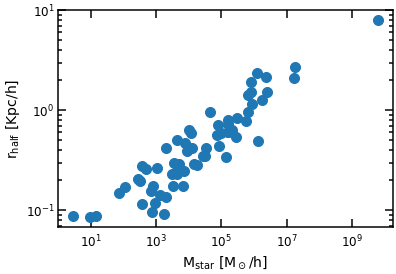

In [ ]:
%matplotlib inline
plt.loglog(gal_Mstar[:, 0], gal_RHalf[:, 0],  "o")
plt.xlabel(r"M$_{\rm star}$ [M$_\odot$/h]")
plt.ylabel(r"r$_{\rm half}$ [Kpc/h]")
# plt.loglog(gal_Mhalo[:,0], gal_Mstar[:,0],  "o")


Mass of the central halo: 3.36e+11


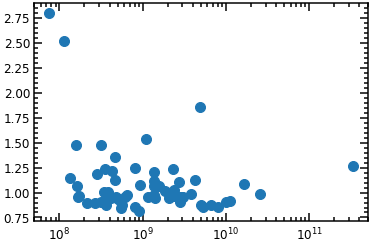

In [ ]:
print("Mass of the central halo: %.2e" % gal_M200[0])
plt.semilogx(gal_M200[:], gal_Mhalo[:, 0]/gal_M200[:],  "o")
